In [7]:
import pandas as pd
import random
import numpy as np
import networkx as nx
import itertools

In [2]:
mu = pd.read_csv('matchups.csv')
st = pd.read_csv('standings.csv')

In [3]:
mud = [[row["Team1"], row["Team2"]] for _, row in mu.iterrows()]
mud

[['EG', 'NZ'], ['IL', 'NZ'], ['AU', 'AF'], ['SL', 'EG']]

In [4]:
std = {row["Team"]: row["Points"] for _, row in st.iterrows()}
std

{'NZ': 5, 'AU': 5, 'SL': 4, 'EG': 3, 'IL': 3, 'AF': 2}

In [66]:
from IPython.display import display

In [81]:
G = nx.DiGraph()

def disp_perc(x):
    return "{:.2%}".format(x)

class WC:
    def __init__(self, matchups: list, standings: dict):
        self.perm = [[int(i) for i in lst] for lst in list(itertools.product("01", repeat=len(matchups)))]
        self.matchups = matchups
        self.standings = standings
        
        self.calc_trajectories()
    
    def win(self, team, std):
        std[team] += 2
        return std

    def sort_std(self, traj_std):
        points = list(traj_std.values())
        max_val = max(points)
        if sum([i == max_val for i in points]) > 1:
            second_max = max_val
        else:
            second_max = max(filter(lambda a: a != max_val, points))
        return ",".join([
            f"{k}{v}"
            for k,v in \
            sorted(traj_std.items(), key=lambda i: i[1], reverse=True)
            if v in (max_val, second_max)])  
            
    def calc_trajectories(self):
        self.all_results = []
        for p in self.perm:
            traj_results = []
            traj_std = self.standings.copy()
            for winner, game in zip(p, self.matchups):
                loser = int(not winner)
                tw = game[winner]
                tl = game[loser]
                res = f"{tw} > {tl}"
                traj_results.append(res)
                traj_std = self.win(tw, traj_std)
            traj_res = self.sort_std(traj_std)
            traj_results.append(traj_res)
            self.all_results.append(traj_results)

    def get_qualifier_traj(self, team):
        return [
            traj
            for traj in self.all_results
            if team in traj[-1]
        ]

    def print_qualifier_traj(self, team):
        valid = self.get_qualifier_traj(team)
        v = len(valid)
        n = len(self.all_results)
        print(f"WAYS FOR {team} TO QUALIFY:")
        print()
        print(f"{v} / {n} possible ways: Likelihood: {disp_perc(v/n)}")
        print()
        df = pd.DataFrame(valid, columns=[f"Game{i+1}" for i in range(len(self.matchups))]+["Standings"])
        display(df)
        # for traj in valid:
        #     print(' | '.join(traj))


In [82]:
wc_ga = WC(mud, std)

In [89]:
wc_ga.print_qualifier_traj('SL')

WAYS FOR SL TO QUALIFY:

5 / 16 possible ways: Likelihood: 31.25%



,Game1,Game2,Game3,Game4,Standings
0,EG > NZ,IL > NZ,AU > AF,SL > EG,"AU7,SL6"
1,EG > NZ,IL > NZ,AF > AU,SL > EG,"SL6,NZ5,AU5,EG5,IL5"
2,EG > NZ,NZ > IL,AF > AU,SL > EG,"NZ7,SL6"
3,NZ > EG,IL > NZ,AF > AU,SL > EG,"NZ7,SL6"
4,NZ > EG,NZ > IL,AF > AU,SL > EG,"NZ9,SL6"


In [84]:
new = []
for i in range(len(traj_results) - 1):
    new.append((traj_results[i], traj_results[i+1]))

new

[('NZ > EG', 'NZ > IL'),
 ('NZ > IL', 'AF > AU'),
 ('AF > AU', 'EG > SL'),
 ('EG > SL', 'NZ9,AU5,EG5')]

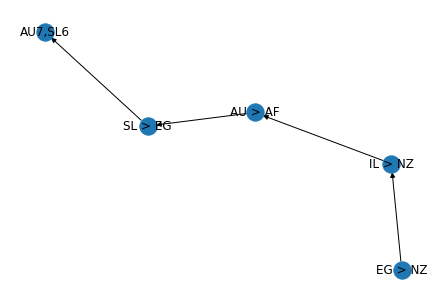

In [28]:
graph = nx.DiGraph()
graph.add_edges_from(new)
nx.draw(graph, with_labels = True)